Задание

Цель: разработать скрипт для сбора и обработки данных с использованием API Binance и прогнозирования временных рядов с помощью LSTM-модели.

In [291]:
import requests 
import json 
import pandas as pd 
import numpy as np  
import datetime as dt  
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import random
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
random.seed(10)

In [137]:
#будем анализировать BTCUSDT c частотой 5 минут и числом наблюдений 1000
frequency = input("Please enter the frequency (1m/5m/30m/.../1h/6h/1d/ :  ")

def get_bars(symbol, interval=frequency):
    root_url = 'https://api.binance.com/api/v3/klines'
    url = root_url + '?symbol=' + symbol + '&interval=' + interval + '&limit=1000' 
    data = json.loads(requests.get(url).text)
    df = pd.DataFrame(data)
    df.columns = ['open_time',
                  'open_price', 'high', 'low', 'close', 'volume',
                  'close_time', 'qav', 'num_trades',
                  'taker_base_vol', 'taker_quote_vol', 'ignore']
    df['date_open'] = pd.to_datetime(df['open_time'], unit = 'ms')
    #df['date_close'] = pd.to_datetime(df['close_time'], unit = 'ms')
    return df

btcusdt = get_bars('BTCUSDT')



df0=pd.DataFrame(btcusdt)
df0.to_csv('_btcusdt.csv')

In [292]:
#в качестве целевого признака примем open_price
data = pd.read_csv('_btcusdt.csv')
data = data.drop(['Unnamed: 0', 'ignore', 'open_time', 'close_time'], axis = 1)
data.tail()


open_price      high       low     close    volume           qav  \
995    28013.99  28013.99  28013.90  28013.91  21.37021  5.986644e+05   
996    28013.91  28032.18  28013.90  28031.62  34.22481  9.589740e+05   
997    28031.62  28032.17  28028.93  28029.45  42.51748  1.191782e+06   
998    28029.45  28041.68  28029.45  28041.67  56.53980  1.585209e+06   
999    28041.68  28046.08  28041.67  28046.08   8.54891  2.397313e+05   

     num_trades  taker_base_vol  taker_quote_vol            date_open  
995        1169        11.46302    321124.750947  2023-04-08 05:25:00  
996        1358        21.03777    589467.772124  2023-04-08 05:30:00  
997        1258        13.57309    380455.535780  2023-04-08 05:35:00  
998        1789        33.57187    941257.259329  2023-04-08 05:40:00  
999         183         4.53500    127171.602821  2023-04-08 05:45:00

In [293]:
data.isna().sum()# нет Nan

open_price         0
high               0
low                0
close              0
volume             0
qav                0
num_trades         0
taker_base_vol     0
taker_quote_vol    0
date_open          0
dtype: int64

In [301]:
data0 = data[['open_price', 'date_open']]
data0.index = pd.to_datetime(data0['date_open'], unit = 'ns')
data0 = data0.drop(['date_open'], axis = 1)
data0

open_price
date_open                      
2023-04-04 18:30:00    28123.18
2023-04-04 18:35:00    28136.10
2023-04-04 18:40:00    28135.69
2023-04-04 18:45:00    28187.48
2023-04-04 18:50:00    28164.39
...                         ...
2023-04-08 05:25:00    28013.99
2023-04-08 05:30:00    28013.91
2023-04-08 05:35:00    28031.62
2023-04-08 05:40:00    28029.45
2023-04-08 05:45:00    28041.68

[1000 rows x 1 columns]

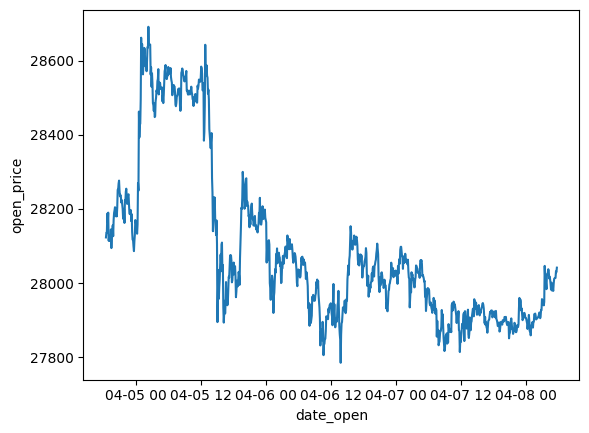

In [302]:
#посмотрим на график для цен на открытие, видно что он нестационарный. В данной работе не будем обрабатывать аномалиии
plt.plot(data0.index, data0['open_price'])
plt.xlabel("date_open")
plt.ylabel("open_price")

plt.show()

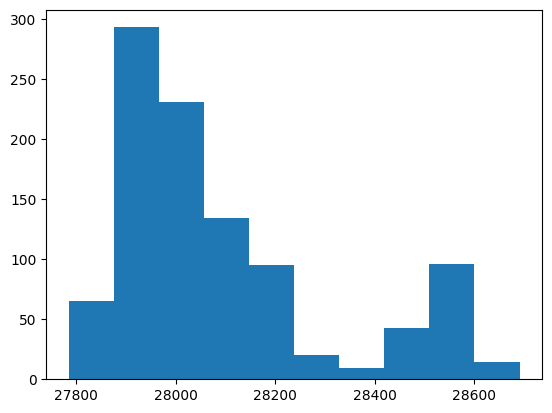

open_price
count   1000.000000
mean   28091.944080
std      218.395211
min    27785.110000
25%    27925.097500
50%    28025.010000
75%    28171.300000
max    28691.280000

In [303]:
#видно что данные имеют бимодальное распределение
itg = data0.describe()
plt.hist(data0)
plt.show()
itg

In [304]:
#ряд более менее однородный и имеет относительно небольшой разброс о чем свидетельствует коэффициент вариации
data0.std()/data0.mean()

open_price    0.007774
dtype: float64

In [305]:
#Проведем тест Харки — Бера для определения номарльности распределения, чтобы подтвердить предположение об однородности.
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = jarque_bera(data0)
a = np.vstack([jb_test])
a, row
#Значение данной статистики свидетельствует о том, нулевая гипотеза о нормальности распределения
#  отвергается с малой вероятностью (probably > 0.05), 
# и, следовательно, наш ряд имеет нормальное распределения. Хотя по графику я бы так не сказал

(array([[2.23699405e+02],
        [2.65638705e-49],
        [1.15494328e+00],
        [3.18223562e+00]]),
 ['JB', 'p-value', 'skew', 'kurtosis'])

In [306]:
#Проверим, являются ли данные стационарным временным рядом, для этого существует обобщенный тест Дикки-Фуллера(например,
#  теорема Волда утверждает что любой стационарный ряд может быть описан моделью ARIMA с любой точностью)
test = adfuller(data0)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -1.8401090361054229
p-value:  0.3607382198733019
Critical values:  {'1%': -3.4369193380671, '5%': -2.864440383452517, '10%': -2.56831430323573}
есть единичные корни, ряд не стационарен


In [307]:
#За счет дифф ряда мы можем стабилизировать среднее значение ряда и избавиться от тренда 
test = adfuller(data0.diff(periods=1).dropna())
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -36.154102079574095
p-value:  0.0
Critical values:  {'1%': -3.4369193380671, '5%': -2.864440383452517, '10%': -2.56831430323573}
единичных корней нет, ряд стационарен


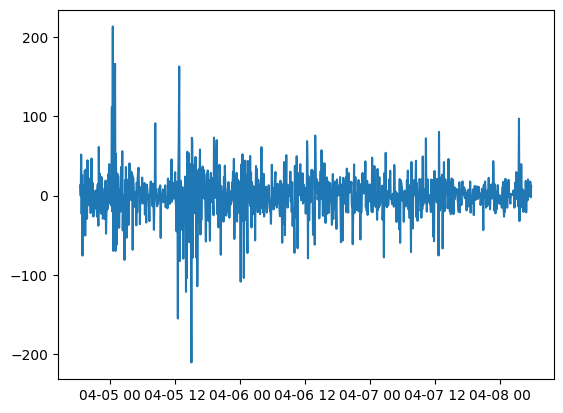

In [308]:
#Тренд действительно отсутствует, таким образом ряд первых разностей является стационарным
plt.plot(data0['open_price'].diff(periods=1).dropna())


plt.show()

In [396]:
#разделение выборки
train_size = int(len(data0) * 0.988)
X_train, X_test = pd.DataFrame(data0.iloc[:train_size, -1]), pd.DataFrame(data0.iloc[train_size:, -1])

In [397]:
X_train.shape, X_test.shape

((988, 1), (12, 1))

In [398]:
X_train

open_price
date_open                      
2023-04-04 18:30:00    28123.18
2023-04-04 18:35:00    28136.10
2023-04-04 18:40:00    28135.69
2023-04-04 18:45:00    28187.48
2023-04-04 18:50:00    28164.39
...                         ...
2023-04-08 04:25:00    28017.56
2023-04-08 04:30:00    28010.01
2023-04-08 04:35:00    27998.00
2023-04-08 04:40:00    27982.64
2023-04-08 04:45:00    28001.22

[988 rows x 1 columns]

In [401]:
#Нормализация
scaler_X = MinMaxScaler()
X_train_nor = scaler_X.fit_transform(X_train)
X_test_nor = scaler_X.transform(X_test)


Одномерный временной ряд

In [430]:
#Для сравнения с LSTM будем использовать ARIMA
from pmdarima import auto_arima

sarimax_param = auto_arima(X_train_nor, exogenous=X_train_nor, m=10, start_p=0, d=1, start_q=0, start_P=0, D=1, start_Q=0, max_p=3, max_q=1, max_P=3, max_Q=1, trace=True, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[10]             : AIC=-3286.992, Time=0.64 sec
 ARIMA(1,1,0)(1,1,0)[10]             : AIC=-3569.093, Time=0.95 sec
 ARIMA(0,1,1)(0,1,1)[10]             : AIC=inf, Time=5.01 sec
 ARIMA(1,1,0)(0,1,0)[10]             : AIC=-3295.634, Time=0.16 sec
 ARIMA(1,1,0)(2,1,0)[10]             : AIC=-3670.806, Time=1.92 sec
 ARIMA(1,1,0)(3,1,0)[10]             : AIC=-3698.837, Time=2.45 sec
 ARIMA(1,1,0)(3,1,1)[10]             : AIC=inf, Time=15.45 sec
 ARIMA(1,1,0)(2,1,1)[10]             : AIC=inf, Time=8.49 sec
 ARIMA(0,1,0)(3,1,0)[10]             : AIC=-3685.729, Time=5.25 sec
 ARIMA(2,1,0)(3,1,0)[10]             : AIC=-3697.333, Time=4.64 sec
 ARIMA(1,1,1)(3,1,0)[10]             : AIC=-3697.345, Time=5.67 sec
 ARIMA(0,1,1)(3,1,0)[10]             : AIC=-3698.022, Time=3.17 sec
 ARIMA(2,1,1)(3,1,0)[10]             : AIC=-3695.307, Time=4.20 sec
 ARIMA(1,1,0)(3,1,0)[10] intercept   : AIC=-3696.837, Time=11.63 sec

Best model:  ARIMA(1

In [431]:
sarimax_param.get_params()["order"], sarimax_param.get_params()["seasonal_order"]

((1, 1, 0), (3, 1, 0, 10))

c:\Users\dmoro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


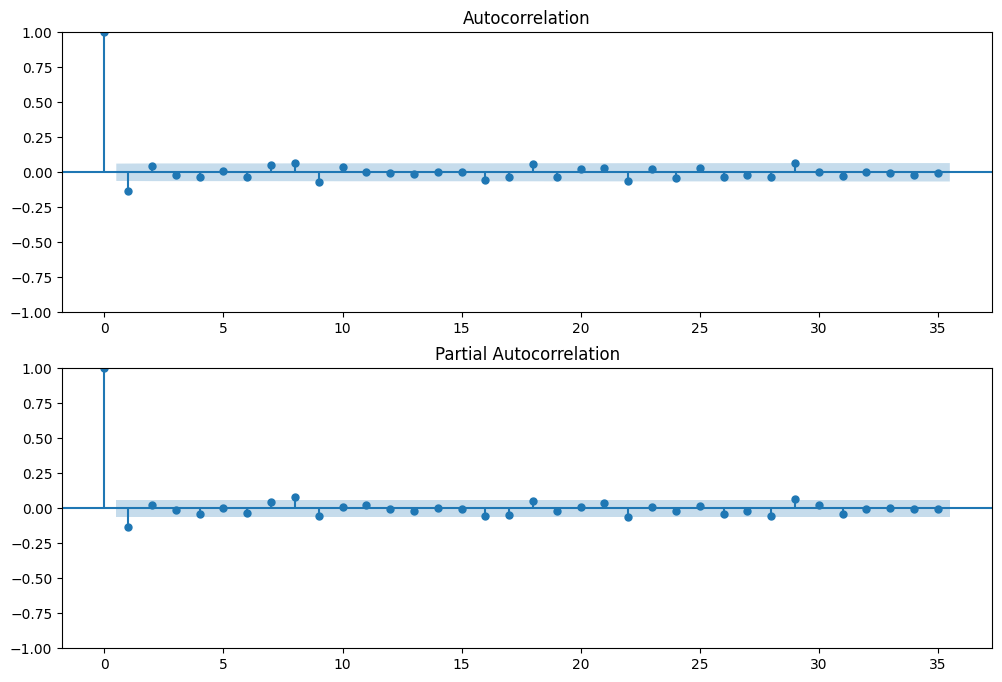

In [404]:
#ACF поможет определить q, т. к. по ее коррелограмме можно определить
#  количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
#PACF поможет нам определить p, т. к. по ее коррелограмме можно определить
#  максимальный номер коэффициента сильно отличный от 0 в модели AR.
#сравним с автоподбором
# в целом автоподбор выбрал правильные параметры
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data0.diff(periods=1).dropna().values.squeeze(), lags=35, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data0.diff(periods=1).dropna(), lags=35, ax=ax2)

In [432]:
model = SARIMAX(endog = X_train_nor, order=sarimax_param.get_params()["order"], seasonal_order=sarimax_param.get_params()["seasonal_order"]).fit(full_output=False, disp=0)

In [433]:
#Как видно из данной информации все коэффициенты значимые и можно перейти к оценке модели.
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  988
Model:             SARIMAX(1, 1, 0)x(3, 1, 0, 10)   Log Likelihood                1854.418
Date:                            Mon, 10 Apr 2023   AIC                          -3698.837
Time:                                    08:59:54   BIC                          -3674.414
Sample:                                         0   HQIC                         -3689.544
                                            - 988                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1251      0.024     -5.183      0.000      -0.172      -0.078
ar.S.L10      -0.7118      0.023   

In [434]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# forecast the data
forecast = model.get_prediction(start=len(X_train_nor), end=len(X_train_nor)+len(X_test_nor)-1, dynamic=True)
prediction = forecast.predicted_mean
ci = forecast.conf_int()

# check error rate
mse = mean_squared_error(X_test, scaler_X.inverse_transform([prediction])[0], squared=False)
rmse = mean_squared_error(X_test, scaler_X.inverse_transform([prediction])[0], squared=True)
print("The error rates of the SARIMAX forecasting are: \nMSE = %f \nRMSE = %f" %(mse, rmse))

The error rates of the SARIMAX forecasting are: 
MSE = 16.572175 
RMSE = 274.636987


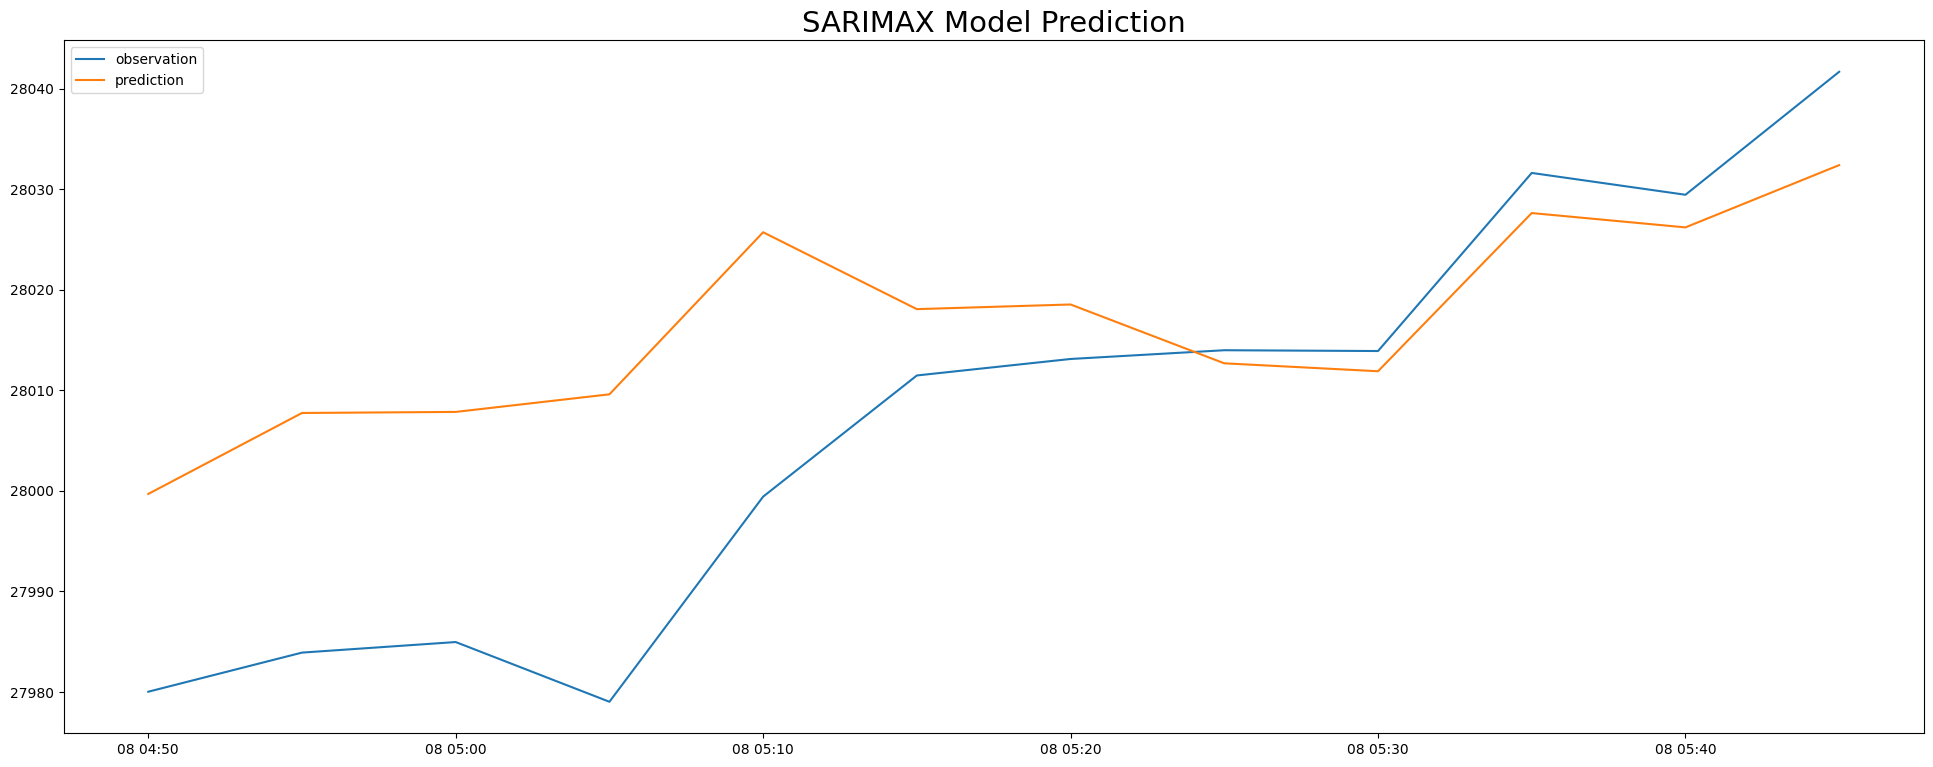

In [440]:
#получили не очень хороший прогноз
plt.figure(figsize=(24, 9))
plt.plot(X_test.index, X_test, label="observation")
plt.plot(X_test.index, scaler_X.inverse_transform([prediction])[0], label="prediction")
plt.title("SARIMAX Model Prediction", fontsize=21)
plt.legend()
plt.show()

In [436]:
#Проверим остатки данной модели на соответствие «белому шуму»
#Значение данной статистики и p-values, свидетельствуют о том, что гипотеза о случайности остатков не отвергается,
# и скорее всего данный процесс представляет «белый шум».
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print(pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

       Q-stat   p-value
0    0.001516  0.968940
1    1.034052  0.596291
2    1.034459  0.792915
3    1.357639  0.851523
4    1.530729  0.909497
5    3.275590  0.773547
6    5.426234  0.608096
7    7.964347  0.436961
8    9.926802  0.356443
9   17.319368  0.067589
10  17.601027  0.091312
11  18.719382  0.095529
12  19.050130  0.121558
13  20.160556  0.125160
14  20.339975  0.159275
15  22.215281  0.136375
16  22.760510  0.157211
17  25.828924  0.103734
18  26.079376  0.127992
19  32.182799  0.041389
20  32.845378  0.047960
21  37.471722  0.020985
22  37.552373  0.028433
23  37.591925  0.038156
24  37.776067  0.048641
25  37.878066  0.062158
26  38.856088  0.065292
27  39.528936  0.072783
28  45.944650  0.023764


Такие плохие результаты могут быть обоснованы наличием аномалий, ARIMA к ним очень чуствителен

LSTM

In [521]:
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential


In [522]:
look_back = 1

In [523]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [524]:
trainX, trainY = create_dataset(X_train_nor, look_back)
testX, testY = create_dataset(X_test_nor, look_back)

In [525]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [526]:
trainX.shape, testX.shape

((986, 1, 1), (10, 1, 1))

In [527]:
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=10, verbose=2)

Epoch 1/100
99/99 - 4s - loss: 0.1515 - 4s/epoch - 44ms/step
Epoch 2/100
99/99 - 0s - loss: 0.0752 - 463ms/epoch - 5ms/step
Epoch 3/100
99/99 - 0s - loss: 0.0492 - 400ms/epoch - 4ms/step
Epoch 4/100
99/99 - 1s - loss: 0.0399 - 701ms/epoch - 7ms/step
Epoch 5/100
99/99 - 1s - loss: 0.0329 - 686ms/epoch - 7ms/step
Epoch 6/100
99/99 - 0s - loss: 0.0258 - 384ms/epoch - 4ms/step
Epoch 7/100
99/99 - 0s - loss: 0.0191 - 400ms/epoch - 4ms/step
Epoch 8/100
99/99 - 0s - loss: 0.0130 - 435ms/epoch - 4ms/step
Epoch 9/100
99/99 - 0s - loss: 0.0082 - 379ms/epoch - 4ms/step
Epoch 10/100
99/99 - 0s - loss: 0.0048 - 415ms/epoch - 4ms/step
Epoch 11/100
99/99 - 0s - loss: 0.0027 - 382ms/epoch - 4ms/step
Epoch 12/100
99/99 - 0s - loss: 0.0017 - 419ms/epoch - 4ms/step
Epoch 13/100
99/99 - 0s - loss: 0.0013 - 415ms/epoch - 4ms/step
Epoch 14/100
99/99 - 0s - loss: 0.0011 - 371ms/epoch - 4ms/step
Epoch 15/100
99/99 - 0s - loss: 0.0010 - 394ms/epoch - 4ms/step
Epoch 16/100
99/99 - 0s - loss: 0.0010 - 419ms/epoc

In [528]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

1/1 [==============================] - 0s 58ms/step


In [529]:
# invert predictions
import math
trainPredict = scaler_X.inverse_transform(trainPredict)
trainY = scaler_X.inverse_transform([trainY])
testPredict = scaler_X.inverse_transform(testPredict)
testY = scaler_X.inverse_transform([testY])

In [530]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 29.11 RMSE
Test Score: 12.59 RMSE


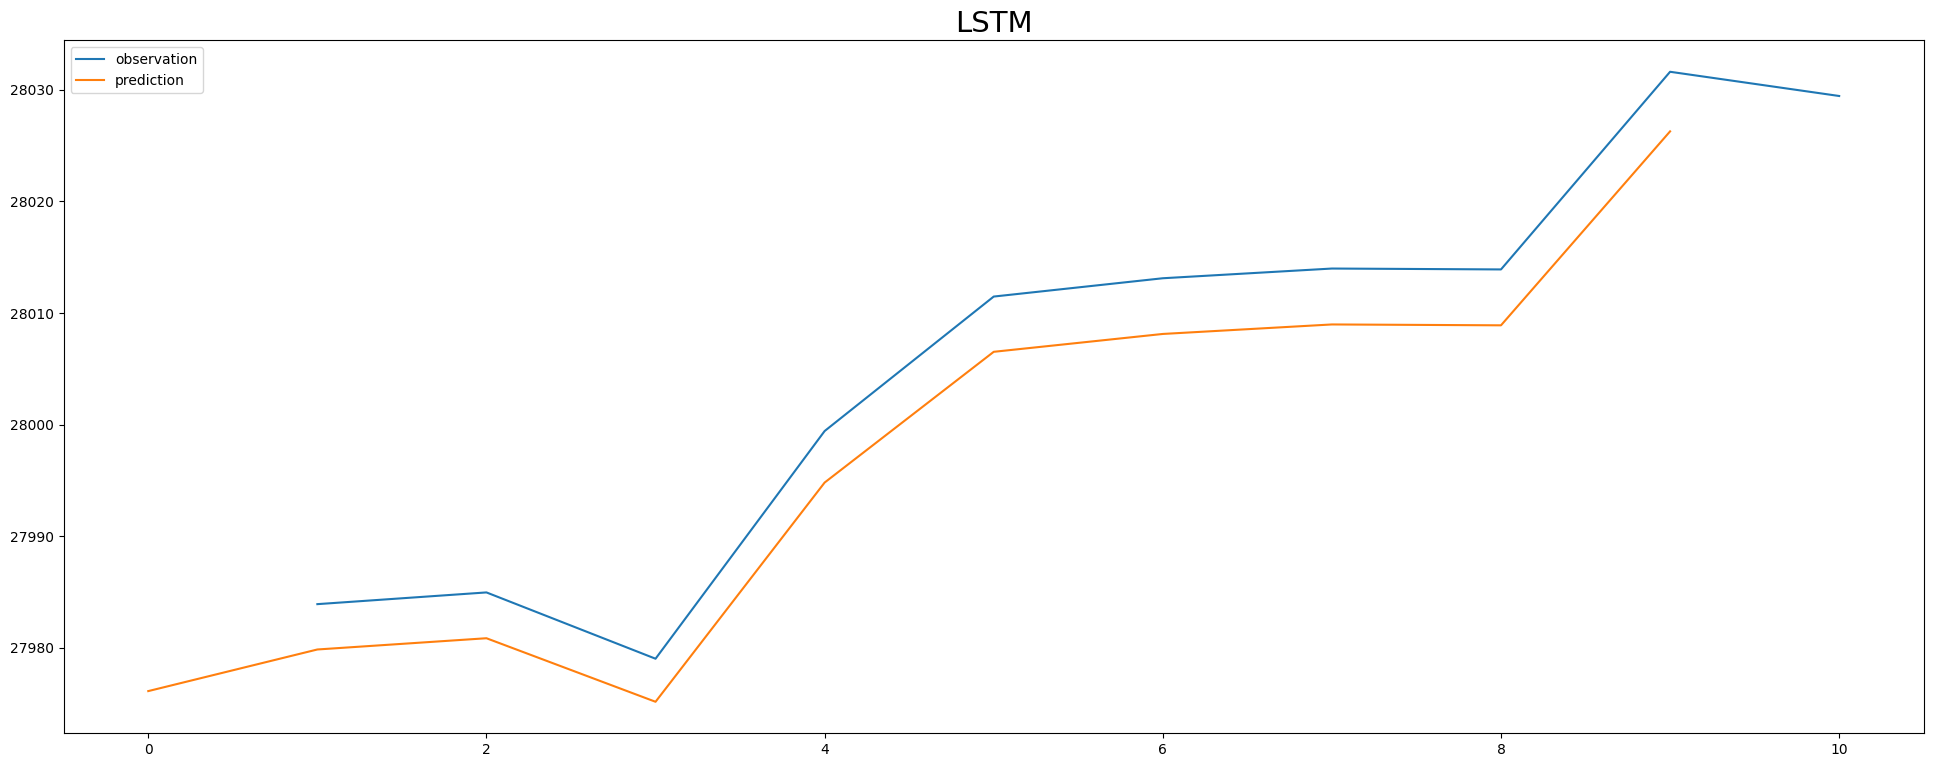

In [543]:

plt.figure(figsize=(24, 9))
plt.plot(range(1,1+len(testY[0])), testY[0], label="observation")
plt.plot(testPredict[:,0], label="prediction")
plt.title("LSTM", fontsize=21)
plt.legend()
plt.show()